In [1]:
#Create by Weirong Dong
#Considering only the GPA, GRE, Ranking parameters
import openpyxl
import torch
from torch.utils.data import DataLoader, random_split

wb = openpyxl.load_workbook("rank_processed.xlsx")
sheet = wb.active

# Read data and convert it to pyctorch tensor
data = []
for row in sheet.iter_rows(min_row=2, values_only=True):
    x = [row[2], row[7], row[8]]  # C、H、I
    x = torch.tensor(x, dtype=torch.float32)
    y = row[10]   # K
    data.append((x, y))

# Division training set and test set
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

# Create a data loader
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1024, shuffle=False)
print(test_loader)

In [2]:
import torch.nn as nn
import torch.optim as optim
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 250)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(250, 250)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(250, 50)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(50, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out
 
def adjust_learning_rate(optimizer, epoch):
    adjust_list = [15]
    if epoch in adjust_list:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5     
 
input_dim = 3
output_dim = 1
learning_rate = 0.1


model = ANN(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 40
train_loss_hist = []
for epoch in range(num_epochs):
    for batch in train_loader:
        x, y = batch
        x = x.to(torch.float32)  
        y = y.to(torch.float32)  

        output = model(x)
        loss = criterion(output, y)

        # Reverse spread and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # After each EPOCH is over, print the loss value of the training set and test set
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        x = x.to(torch.float32)  
        y = y.to(torch.float32)  
        output = model(x)
        loss = criterion(output, y)
        train_loss += loss.item() * x.shape[0]
    train_loss /= len(train_loader.dataset)
    train_loss_hist.append(train_loss)
    adjust_learning_rate(optimizer, epoch)

    test_loss = 0.0
    for batch in test_loader:
        x, y = batch
        x = x.to(torch.float32)  
        y = y.to(torch.float32)  
        output = model(x)
        loss = criterion(output, y)
        test_loss += loss.item() * x.shape[0]
    test_loss /= len(test_loader.dataset)
    

    print(f'Epoch {epoch + 1}: Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')


/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([284])) that is different to the input size (torch.Size([284, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(i

Epoch 1: Train loss: 0.2931, Test loss: 0.2948
Epoch 2: Train loss: 0.2599, Test loss: 0.2605
Epoch 3: Train loss: 0.2544, Test loss: 0.2548
Epoch 4: Train loss: 0.2532, Test loss: 0.2535
Epoch 5: Train loss: 0.2529, Test loss: 0.2532
Epoch 6: Train loss: 0.2529, Test loss: 0.2531
Epoch 7: Train loss: 0.2528, Test loss: 0.2531
Epoch 8: Train loss: 0.2528, Test loss: 0.2531
Epoch 9: Train loss: 0.2528, Test loss: 0.2531
Epoch 10: Train loss: 0.2528, Test loss: 0.2530
Epoch 11: Train loss: 0.2528, Test loss: 0.2530
Epoch 12: Train loss: 0.2528, Test loss: 0.2530
Epoch 13: Train loss: 0.2528, Test loss: 0.2530
Epoch 14: Train loss: 0.2528, Test loss: 0.2530
Epoch 15: Train loss: 0.2528, Test loss: 0.2530
Epoch 16: Train loss: 0.2528, Test loss: 0.2530
Epoch 17: Train loss: 0.2528, Test loss: 0.2530
Epoch 18: Train loss: 0.2528, Test loss: 0.2530
Epoch 19: Train loss: 0.2528, Test loss: 0.2530
Epoch 20: Train loss: 0.2528, Test loss: 0.2530
Epoch 21: Train loss: 0.2528, Test loss: 0.2530
E

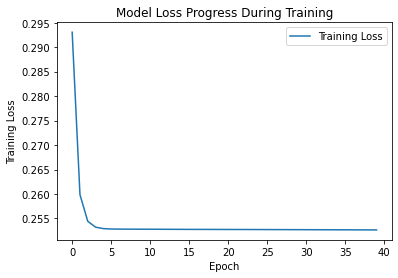

In [3]:
import matplotlib.pyplot as plt

#Plot the training loss over time
plt.plot(range(num_epochs), train_loss_hist)
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training Loss'])